In [ ]:
pip install git+https://github.com/stefanradev93/bayesflow

Attention: Restart the runtime after installing bayesflow

# **Import**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from scipy import stats
import pickle

import tensorflow as tf


from tqdm import tqdm
from scipy.integrate import solve_ivp
from scipy import signal


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM

In [4]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

import bayesflow.diagnostics as diag
from bayesflow import benchmarks
from bayesflow.coupling_networks import CouplingLayer
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d
from bayesflow.mcmc import MCMCSurrogateLikelihood

/usr/local/lib/python3.10/dist-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm






# **Generative Model Setup**

In [ ]:
def prior_sample(Initial_Params = None):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    if Initial_Params == None:
      N_0 = 1000
      I_0 = 0
      E_0 = 0
      D_0 = 3000
    else:
      N_0 = Initial_Params[0]
      I_0 = Initial_Params[1]
      E_0 = Initial_Params[2]
      D_0 = Initial_Params[3]

    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)



In [ ]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [ ]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [1000,0,0,3000]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  return np.stack([N_sol/scale_N, I_sol/scale_I, D_sol/scale_D, E_sol/scale_E])

In [ ]:
Nonlinear_Solver(prior_sample()[0],0.5).shape


(4, 56)

In [ ]:
def simulate(N,T):
  data = {}
  data['Prior'] = np.ndarray((0,6))
  #data['Time_Series'] = np.ndarray((0,4,T+1))
  data['Time_Series'] = np.ndarray((0,4,56))
  for i in range(N):
    prior = prior_sample()
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
  for p in range(data['Prior'].shape[0]):
    #TS = Nonlinear_Solver(data['Prior'][p],T).reshape((1,4,T+1))
    TS = Nonlinear_Solver(data['Prior'][p],T).reshape((1,4,56))
    data['Time_Series'] = np.concatenate((data['Time_Series'], TS), axis=0)
  return data

In [ ]:
T = 0.5
d = simulate(4,T)
#x = np.linspace(0, 1, num=T+1)
x = np.linspace(0, 1, num=56)
params = d['Prior']
sim_data = d['Time_Series']
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax = ax.flat

for i, data in enumerate(sim_data):
    ax[i].plot(x, data[0])
    ax[i].plot(x, data[1])
    ax[i].plot(x, data[2])
    ax[i].plot(x, data[3])
    ax[i].set_xlabel("Time t [s]")
    ax[i].set_ylabel("Solution N,I,D,E")
    ax[i].grid(True)
    #ax[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
def data_generator(batch_size, T):

  """
  Runs the forward model 'batch_size' times by first sampling fromt the prior
  theta ~ p(theta) and running x ~ p(x|theta).
  ----------

  Arguments:
  batch_size : int -- the number of samples to draw from the prior
  ----------

  Output:
  forward_dict : dict
      The expected outputs for a BayesFlow pipeline
  """

  # Generate data
  data = simulate(batch_size,T)
  forward_dict = {"prior_draws": data['Prior'], "sim_data": np.transpose(data['Time_Series'], axes=[0, 2, 1])}
  return forward_dict

In [ ]:
generative_model = partial(data_generator, T=0.5)

# Load Data


In [9]:
# Read dictionary pkl file
with open('/Simulated_Data/Training_Test_Sets/Time_Series_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

In [10]:
training_data = {}
training_data['prior_draws'] = d['Prior'][320:6720]
training_data['sim_data'] = np.transpose(signal.decimate(d['Time_Series'][320:6720,:,:],50), axes=[0, 2, 1])

# Network

**Summery Network**

In [11]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""

    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()

        self.convs = [
            tf.keras.layers.Conv1D(
                n_filters // 2,
                kernel_size=f,
                strides=strides,
                padding="causal",
                activation="relu",
                kernel_initializer="glorot_uniform",
            )
            for f in range(2, 8)
        ]
        self.dim_red = tf.keras.layers.Conv1D(
            n_filters, 1, 1, activation="relu", kernel_initializer="glorot_uniform"
        )

    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""

        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out


class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""

    def __init__(self, n_layers = 4, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()

        self.net = tf.keras.Sequential(
            [MultiConvLayer(n_filters, strides) for _ in range(n_layers)]
        )

        self.lstm = LSTM(n_filters)

    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""

        out = self.net(x)
        out = self.lstm(out)
        return out


class SummaryNet(tf.keras.Model):
  def __init__(self, n_summary):

    super(SummaryNet, self).__init__()
    self.net_N = MultiConvNet(n_filters=n_summary // 4)
    self.net_I = MultiConvNet(n_filters=n_summary // 4)
    self.net_D = MultiConvNet(n_filters=n_summary // 4)
    self.net_E = MultiConvNet(n_filters=n_summary // 4)

  @tf.function
  def call(self, x, **args):

    """x is a timeseries of dimensions B timestamps, n_features"""

    x = tf.split(x, 4, axis=-1)
    x_n = self.net_N(x[0])
    x_i = self.net_I(x[1])
    x_d = self.net_D(x[2])
    x_e = self.net_E(x[3])
    return tf.concat([x_n, x_i, x_d, x_e], axis=-1)

**Recurrent Memmory**

In [12]:
class MemoryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(MemoryNetwork, self).__init__()

        self.gru = GRU(meta["n_hidden"], return_sequences=True, return_state=True)
        self.h = meta["n_hidden"]
        self.n_params = meta["n_params"]

    @tf.function
    def call(self, target, condition):
        """Performs a forward pass through the network.

        Params:
        -------
        target    : tf.Tesnor of shape (batch_size, time_stes, dim)
            The time-dependent signal to process.
        condition : tf.Tensor of shape (batch_size, cond_dim)
            The conditional (static) variables, e.g., parameters.
        """
        shift_target = target[:, :-1, :]
        init = tf.zeros((target.shape[0], 1, target.shape[2]))
        inp_teacher = tf.concat([init, shift_target], axis=1)
        inp_teacher_c = tf.concat([inp_teacher, condition], axis=-1)
        out, _ = self.gru(inp_teacher_c)
        return out

    def step_loop(self, target, condition, state):
        out, new_state = self.gru(
            tf.concat([target, condition], axis=-1), initial_state=state
        )
        return out, new_state

**Invertible Network with Memory**

In [13]:
class InvertibleNetworkWithMemory(tf.keras.Model):
    """Implements a chain of conditional invertible blocks for Bayesian parameter inference."""

    def __init__(
        self,
        num_params,
        num_coupling_layers=4,
        coupling_settings=None,
        coupling_design="affine",
        permutation="fixed",
        use_act_norm=True,
        act_norm_init=None,
        use_soft_flow=False,
        soft_flow_bounds=(1e-3, 5e-2),
    ):
        """Initializes a custom invertible network with recurrent memory."""

        super().__init__()

        # Create settings dict for coupling layer
        settings = dict(
            latent_dim=num_params,
            coupling_settings=coupling_settings,
            coupling_design=coupling_design,
            permutation=permutation,
            use_act_norm=use_act_norm,
            act_norm_init=act_norm_init,
        )

        # Create sequence of coupling layers and store reference to dimensionality
        self.coupling_layers = [
            CouplingLayer(**settings) for _ in range(num_coupling_layers)
        ]

        # Store attributes
        self.soft_flow = use_soft_flow
        self.soft_low = soft_flow_bounds[0]
        self.soft_high = soft_flow_bounds[1]
        self.use_act_norm = use_act_norm
        self.latent_dim = num_params
        self.dynamic_summary_net = MemoryNetwork({"n_hidden": 256, "n_params": 3})
        self.latent_dim = num_params

    def call(self, targets, condition, inverse=False):
        """Performs one pass through an invertible chain (either inverse or forward).

        Parameters
        ----------
        targets   : tf.Tensor
            The estimation quantities of interest, shape (batch_size, ...)
        condition : tf.Tensor
            The conditional data x, shape (batch_size, summary_dim)
        inverse   : bool, default: False
            Flag indicating whether to run the chain forward or backwards

        Returns
        -------
        (z, log_det_J)  :  tuple(tf.Tensor, tf.Tensor)
            If inverse=False: The transformed input and the corresponding Jacobian of the transformation,
            v shape: (batch_size, ...), log_det_J shape: (batch_size, ...)

        target          :  tf.Tensor
            If inverse=True: The transformed out, shape (batch_size, ...)

        Important
        ---------
        If ``inverse=False``, the return is ``(z, log_det_J)``.\n
        If ``inverse=True``, the return is ``target``.
        """

        if inverse:
            return self.inverse(targets, condition)
        return self.forward(targets, condition)

    @tf.function
    def forward(self, targets, condition, **kwargs):
        """Performs a forward pass though the chain."""

        # Add memory condition
        memory = self.dynamic_summary_net(targets, condition)
        condition = tf.concat([memory, condition], axis=-1)

        z = targets
        log_det_Js = []
        for layer in self.coupling_layers:
            z, log_det_J = layer(z, condition, **kwargs)
            log_det_Js.append(log_det_J)
        # Sum Jacobian determinants for all layers (coupling blocks) to obtain total Jacobian.
        log_det_J = tf.add_n(log_det_Js)
        return z, log_det_J

    @tf.function
    def inverse(self, z, condition, **kwargs):
        """Performs a reverse pass through the chain."""

        target = z
        T = z.shape[1]
        gru_inp = tf.zeros((z.shape[0], 1, z.shape[-1]))
        state = tf.zeros((z.shape[0], self.dynamic_summary_net.h))
        outs = []
        for t in range(T):
            # One step condition
            memory, state = self.dynamic_summary_net.step_loop(
                gru_inp, condition[:, t : t + 1, :], state
            )
            condition_t = tf.concat([memory, condition[:, t : t + 1, :]], axis=-1)
            target_t = target[:, t : t + 1, :]
            for layer in reversed(self.coupling_layers):
                target_t = layer(target_t, condition_t, inverse=True, **kwargs)
            outs.append(target_t)
            gru_inp = target_t
        return tf.concat(outs, axis=1)

# Configurator

In [14]:
def configurator(forward_dict):
    """Customized preprocessing for the Covid simulator."""

    out = {"posterior_inputs": {}, "likelihood_inputs": {}}

    # Extract data
    x = forward_dict["sim_data"].astype(np.float32)
    x_means = np.mean(x, axis=1, keepdims=True)
    x_std = np.std(x, axis=1, keepdims=True)
    x = (x - x_means) / x_std
    log_mu = np.log2(1 + x_means[:, 0, :])
    log_std = np.log2(1 + x_std[:, 0, :])

    # Extract params
    p = forward_dict["prior_draws"].astype(np.float32)
    #p = (p - theta_mu) / theta_std

    # Repeat condition
    cond = np.concatenate([p, log_mu, log_std], axis=-1)
    cond = np.stack([cond] * x.shape[1], axis=1)

    # Likelihood inputs
    out["likelihood_inputs"]["observables"] = x.astype(np.float32)
    out["likelihood_inputs"]["conditions"] = np.concatenate([cond], axis=-1).astype(
        np.float32
    )

    # Posterior inputs
    out["posterior_inputs"]["parameters"] = p
    out["posterior_inputs"]["summary_conditions"] = out["likelihood_inputs"][
        "observables"
    ]
    out["posterior_inputs"]["direct_conditions"] = np.concatenate(
        [log_mu, log_std], axis=-1
    )

    return out

In [15]:
coupling_settings = {
    "dense_args": dict(units=128, activation="swish", kernel_regularizer=None),
    "num_dense": 2,
    "dropout": False,
}

In [16]:
likelihood_net = InvertibleNetworkWithMemory(
    num_params=4, num_coupling_layers=8, coupling_settings=coupling_settings
)
posterior_net = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=6,
    coupling_settings=coupling_settings,
)
summary_net = SummaryNet(n_summary=10)
amortized_posterior = AmortizedPosterior(
    posterior_net, summary_net, summary_loss_fun="MMD"
)
amortized_likelihood = AmortizedLikelihood(likelihood_net)
joint_amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior, amortized_likelihood
)

# Train

**Train**

In [17]:
trainer = Trainer(
    amortizer=joint_amortizer,
    #generative_model=generative_model,
    configurator=configurator
    #checkpoint_path= 'Checkpoint'
    )

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [ ]:
# in case of continue training from a pretrined network
trainer.load_pretrained_network()

False

In [18]:
h = trainer.train_offline(training_data ,epochs=1, batch_size=64)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

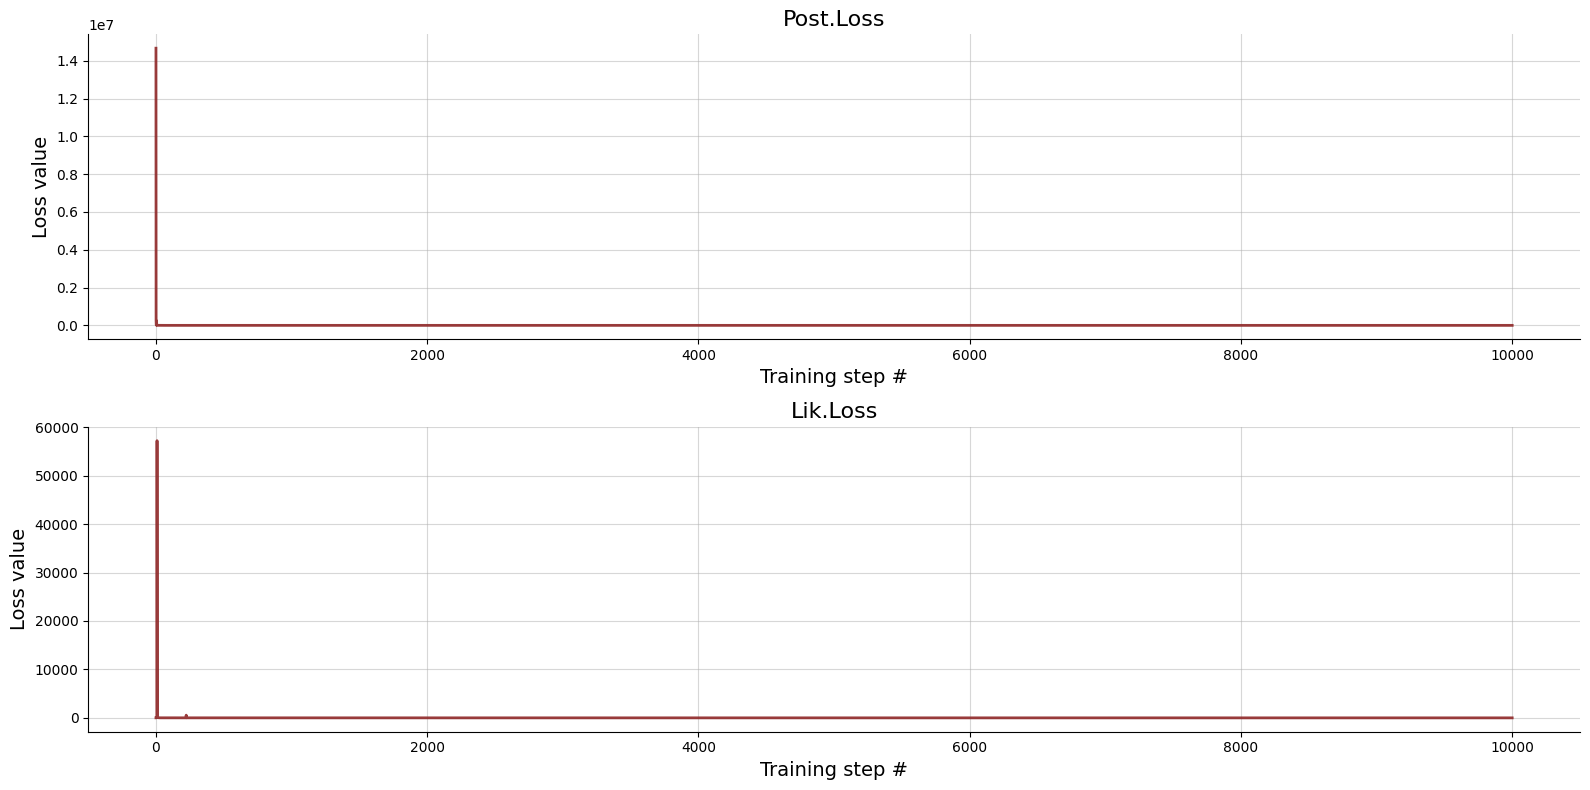

In [ ]:
fig = diag.plot_losses(h)

**Test**

In [20]:
#data = simulate(1,0.5)
#net_in = configurator({"sim_data": np.transpose(d['Sampled_Time_Series'][0:1,:,:], axes=[0, 2, 1]), "prior_draws": d['Prior'][0:1]})
#means_out = np.mean(sim_out, axis=1)
#stds_out = np.std(sim_out, axis=1)
training_data['sim_data']
net_in = configurator({"sim_data": training_data['sim_data'][0:1,:,:], "prior_draws": d['Prior'][0:1]})

In [25]:
import time

s = time.time()
net_out = amortized_likelihood.sample(net_in["likelihood_inputs"], 21)
e = time.time()

print("Time Of Execution = ", e-s)

Time Of Execution =  58.19968867301941


In [ ]:
# Generate surrogate simulations given parameters
khar = np.zeros((50,1,4))
for i in range(50):
  net_out = amortized_likelihood.sample(net_in["likelihood_inputs"], 1)
  khar[i] = net_out

net_out = np.nanmean(khar,axis = 0)
net_out.shape

(1, 4)

In [ ]:
net_out

array([[-0.0891675 , -0.05106504, -0.10650038,  0.12964468]])

In [ ]:
training_data['sim_data'][0,0,0]

3292.9572949374588

:))))
Maybe it's time for me to say goodbye to engineering field !

In [ ]:
x = np.linspace(0, 1, num=1)
plt.plot(x,training_data['sim_data'][0,0,0])
plt.plot(x,net_out[:,0])
#plt.plot(x,data['Time_Series'][30025:30026,2,:][0])
#plt.plot(x,data['Time_Series'][30025:30026,3,:][0])
plt.show()